Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.

In [63]:
import pandas as pd
import numpy as np

In [64]:
df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [66]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Drop Unnecessary Columns

The Unnamed: 0 and key columns don’t provide useful information for prediction, so drop them.

In [67]:
df.drop(columns=['Unnamed: 0', 'key'], inplace=True)
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543
std,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995
min,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [68]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 12.2 MB


feature enginnering on pickup_datetime

In [69]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['pickup_datetime'].dt.month
df.drop(columns=['pickup_datetime'], inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_month
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,19,3,5
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,20,4,7
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,21,0,8
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,8,4,6
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,17,3,8


Identify Outliers

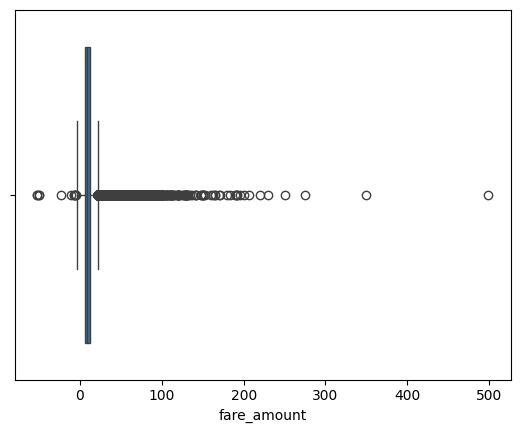

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['fare_amount'])
plt.show()


In [71]:
# Remove fare_amount outliers based on quantiles
q_low = df["fare_amount"].quantile(0.01)
q_hi = df["fare_amount"].quantile(0.99)
df = df[(df["fare_amount"] > q_low) & (df["fare_amount"] < q_hi)]

# Apply reasonable geographical bounds for longitude and latitude
df = df[(df['pickup_longitude'] > -74.3) & (df['pickup_longitude'] < -73.7)]
df = df[(df['dropoff_longitude'] > -74.3) & (df['dropoff_longitude'] < -73.7)]
df = df[(df['pickup_latitude'] > 40.5) & (df['pickup_latitude'] < 41)]
df = df[(df['dropoff_latitude'] > 40.5) & (df['dropoff_latitude'] < 41)]

# Filter passenger_count to a reasonable range
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]


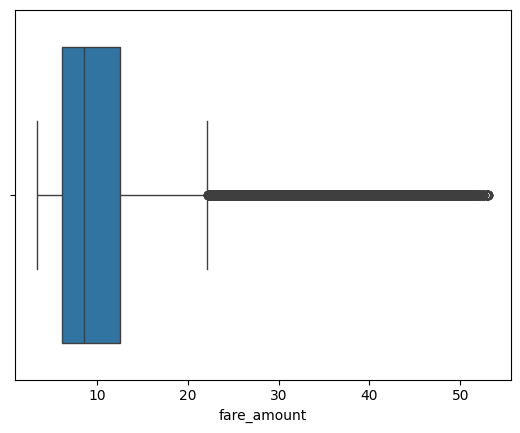

In [72]:
sns.boxplot(x=df['fare_amount'])
plt.show()

Check the correlation

In [74]:
correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()
correlation_matrix

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,pickup_day,pickup_month
fare_amount,1.000000,0.403295,-0.170972,0.391631,-0.156674,0.012205,-0.021843,0.005758,0.027732
pickup_longitude,0.403295,1.000000,0.051331,0.329978,0.050587,-0.003368,0.018581,-0.023641,0.004893
pickup_latitude,-0.170972,0.051331,1.000000,0.062455,0.446389,-0.009763,0.029908,-0.042770,0.000005
dropoff_longitude,0.391631,0.329978,0.062455,1.000000,0.177910,-0.004831,-0.053444,0.000441,0.006473
dropoff_latitude,-0.156674,0.050587,0.446389,0.177910,1.000000,-0.004702,0.018000,-0.031657,-0.001011
passenger_count,0.012205,-0.003368,-0.009763,-0.004831,-0.004702,1.000000,0.015166,0.035957,0.008907
pickup_hour,-0.021843,0.018581,0.029908,-0.053444,0.018000,0.015166,1.000000,-0.086747,-0.004067
pickup_day,0.005758,-0.023641,-0.042770,0.000441,-0.031657,0.035957,-0.086747,1.000000,-0.009904
pickup_month,0.027732,0.004893,0.000005,0.006473,-0.001011,0.008907,-0.004067,-0.009904,1.000000


Implement Linear Regression and Random Forest Regression Models

In [75]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
from sklearn.linear_model import LinearRegression

# Initialize and train
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)


In [78]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train
rf_model = RandomForestRegressor(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)


In [79]:
from sklearn.metrics import r2_score, mean_squared_error

# Linear Regression metrics
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Random Forest metrics
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Linear Regression -> R2: {r2_lr}, RMSE: {rmse_lr}")
print(f"Random Forest -> R2: {r2_rf}, RMSE: {rmse_rf}")


Linear Regression -> R2: 0.303809794592667, RMSE: 6.657725655894189
Random Forest -> R2: 0.8262715367058839, RMSE: 3.325809962061048
